# Logistic Regression with L2 regularization

The goal of this second notebook is to implement your own logistic regression classifier with L2 regularization. You will do the following:

 * Extract features from Amazon product reviews.
 * Convert a DataFrame into a NumPy array.
 * Write a function to compute the derivative of log likelihood function with an L2 penalty with respect to a single coefficient.
 * Implement gradient ascent with an L2 penalty.
 * Empirically explore how the L2 penalty can ameliorate overfitting.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import json
import string
from math import sqrt
import ast

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from __future__ import division

## Load and process review dataset

For this assignment, we will use the same subset of the Amazon product review dataset that we used in Module 3 assignment. The subset was chosen to contain similar numbers of positive and negative reviews, as the original dataset consisted of mostly positive reviews.

In [5]:
products = pd.read_csv("./data/amazon_baby_subset.csv", index_col=False)

Just like we did previously, we will work with a hand-curated list of important words extracted from the review data. We will also perform 2 simple data transformations:

1. Remove punctuation using [Python's built-in](https://docs.python.org/2/library/string.html) string functionality.
2. Compute word counts (only for the **important_words**)

But first we replace NaN reviews with " " to avoid errors when processing texts later on.

In [6]:
products["review"].fillna(" ",inplace=True)

### We start with Step 1 which can be done as follows:

In [7]:
def remove_punctuation(text):
    # str.maketrans create a translation table
    # The translation table is built from a dictionary using a comprehension
    # this maps every character from string.punctuation to None
    translator = str.maketrans({key: None for key in string.punctuation})
    return text.translate(translator)

products["review_clean"] = products["review"].apply(remove_punctuation)

### Now we proceed with Step 2.
For each word in **important_words**, we compute a count for the number of times the word occurs in the review. We will store this count in a separate column (one for each word). The result of this feature processing is a single column for each word in **important_words** which keeps a count of the number of times the respective word occurs in the review text.

**Note:** There are several ways of doing this. In this assignment, we use the built-in count function for Python lists. Each review string is first split into individual words and the number of occurances of a given word is counted.

Let's load these words from this JSON file first:

In [8]:
with open("./data/important_words.json", "r") as f:
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

In [9]:
%%time
for word in important_words:
    products[word] = products["review_clean"].apply(lambda s : s.split().count(word))

Wall time: 1min 55s


Now, let us take a look at what the dataset looks like (**Note:** This may take a few minutes).

In [10]:
products.head(2)

,name,review,rating,sentiment,review_clean,baby,one,great,love,use,...,seems,picture,completely,wish,buying,babies,won,tub,almost,either
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried non-stop when I trie...,5,1,All of my kids have cried nonstop when I tried...,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1,We wanted to get something to keep track of ou...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Train-Validation split

We split the data into a train-validation split with 80% of the data in the training set and 20% of the data in the validation set. We use `seed=2` so that everyone gets the same result.

**Note:** In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters**. Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on a validation set, while evaluation of selected model should always be on a test set.

### Load training and test sets
Load the **training set** from file provided by the course.

In [11]:
f = open("./data/module-4-assignment-train-idx.json")
train_data_index = f.readline()
f.close()

# Transform the read string into a list
train_data_index = ast.literal_eval(train_data_index)

train_data = products.loc[train_data_index]

Load the **validation set** from file provided by the course.

In [12]:
f = open("./data/module-4-assignment-validation-idx.json")
validation_data_index = f.readline()
f.close()

# Transform the read string into a list
validation_data_index = ast.literal_eval(validation_data_index)

validation_data = products.loc[validation_data_index]

## Convert DataFrame to NumPy array

Just like in the second assignment of the previous module, we provide you with a function that extracts columns from a DataFrame and converts them into a NumPy array. Two arrays are returned: one representing features and another representing class labels. 

**Note:** The feature matrix includes an additional column 'intercept' filled with 1's to take account of the intercept term.

In [13]:
def get_numpy_data(dataframe, features, label):
    
    # transform dataframe[features] into numpy array
    feature_matrix = dataframe.as_matrix(features)
    
    # add feature x0 (i.e. a ones column vector)!
    feature_matrix = np.insert(feature_matrix,0,np.ones([1,feature_matrix.shape[0]]),axis=1)
    
    label_array = dataframe.as_matrix(label)
    
    return(feature_matrix, label_array)

We convert both the training and validation sets into NumPy arrays.

**Warning**: This may take a few minutes.

In [14]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, ["sentiment"])
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, ["sentiment"]) 

**Are you running this notebook on an Amazon EC2 t2.micro instance?** (If you are using your own machine, please skip this section)

It has been reported that t2.micro instances do not provide sufficient power to complete the conversion in acceptable amount of time. For interest of time, please refrain from running `get_numpy_data` function. Instead, download the [binary file](https://s3.amazonaws.com/static.dato.com/files/coursera/course-3/numpy-arrays/module-4-assignment-numpy-arrays.npz) containing the four NumPy arrays you'll need for the assignment. To load the arrays, run the following commands:
```
arrays = np.load('module-4-assignment-numpy-arrays.npz')
feature_matrix_train, sentiment_train = arrays['feature_matrix_train'], arrays['sentiment_train']
feature_matrix_valid, sentiment_valid = arrays['feature_matrix_valid'], arrays['sentiment_valid']
```

## Building on logistic regression with no L2 penalty assignment

Let us now build on Module 3 assignment. Recall from lecture that the link function for logistic regression can be defined as:

$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$

where the feature vector $h(\mathbf{x}_i)$ is given by the word counts of **important_words** in the review $\mathbf{x}_i$. 

We will use the **same code** as in this past assignment to make probability predictions since this part is not affected by the L2 penalty.  (Only the way in which the coefficients are learned is affected by the addition of a regularization term.)

In [15]:
def predict_probability(feature_matrix, coefficients):
    
    scores = np.dot(feature_matrix,np.transpose(coefficients))
    
    # Compute P(y_i = +1 | x_i, w) using the link function
    predictions = 1/(1+np.exp(-scores))
    
    return predictions.reshape(-1,1)

# Adding  L2 penalty

Let us now work on extending logistic regression with L2 regularization. As discussed in the lectures, the L2 regularization is particularly useful in preventing overfitting. In this assignment, we will explore L2 regularization in detail.

Recall from lecture and the previous assignment that for logistic regression without an L2 penalty, the derivative of the log likelihood function is:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

** Adding L2 penalty to the derivative** 

It takes only a small modification to add a L2 penalty. All terms indicated in **red** refer to terms that were added due to an **L2 penalty**.

* Recall from the lecture that the link function is still the sigmoid:
$$
P(y_i = +1 | \mathbf{x}_i,\mathbf{w}) = \frac{1}{1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))},
$$
* We add the L2 penalty term to the per-coefficient derivative of log likelihood:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$

The **per-coefficient derivative for logistic regression with an L2 penalty** is as follows:
$$
\frac{\partial\ell}{\partial w_j} = \sum_{i=1}^N h_j(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right) \color{red}{-2\lambda w_j }
$$
and for the intercept term, we have
$$
\frac{\partial\ell}{\partial w_0} = \sum_{i=1}^N h_0(\mathbf{x}_i)\left(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w})\right)
$$

**Note**: As we did in the Regression course, we do not apply the L2 penalty on the intercept. A large intercept does not necessarily indicate overfitting because the intercept is not associated with any particular feature.

Write a function that computes the derivative of log likelihood with respect to a single coefficient $w_j$. Unlike its counterpart in the last assignment, the function accepts five arguments:
 * `errors` vector containing $(\mathbf{1}[y_i = +1] - P(y_i = +1 | \mathbf{x}_i, \mathbf{w}))$ for all $i$
 * `feature` vector containing $h_j(\mathbf{x}_i)$  for all $i$
 * `coefficient` containing the current value of coefficient $w_j$.
 * `l2_penalty` representing the L2 penalty constant $\lambda$
 * `feature_is_constant` telling whether the $j$-th feature is constant or not.

In [16]:
def feature_derivative_with_L2(errors, feature, coefficient, l2_penalty, feature_is_constant): 
    
    # When used in compute_log_likelihood_with_L2, feature is [1,n], i.e. row vector
    # and errors is a column vector. So we need to do np.dot(feature, errors)
    derivative = np.dot(feature, errors)
    
    # if feature is intercept do nothing
    # else add the regularisation term -2*lambda*wj
    if not feature_is_constant: 
        derivative = derivative - 2*l2_penalty*coefficient
        
    return derivative

** Quiz question:** In the code above, was the intercept term regularized?

To verify the correctness of the gradient ascent algorithm, we provide a function for computing log likelihood (which we recall from the last assignment was a topic detailed in an advanced optional video, and used here for its numerical stability).

$$\ell\ell(\mathbf{w}) = \sum_{i=1}^N \Big( (\mathbf{1}[y_i = +1] - 1)\mathbf{w}^T h(\mathbf{x}_i) - \ln\left(1 + \exp(-\mathbf{w}^T h(\mathbf{x}_i))\right) \Big) \color{red}{-\lambda\|\mathbf{w}\|_2^2} $$

In [17]:
def compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty):
    indicator = (sentiment==+1).reshape(-1,1)
    scores = np.dot(feature_matrix, coefficients).reshape(-1,1)
    lp = np.sum((indicator-1)*scores - np.log(1. + np.exp(-scores))) - l2_penalty*np.sum(coefficients[1:]**2)
    return lp

** Quiz question:** Does the term with L2 regularization increase or decrease $\ell\ell(\mathbf{w})$?

The logistic regression function looks almost like the one in the last assignment, with a minor modification to account for the L2 penalty.  Fill in the code below to complete this modification.

In [18]:
def logistic_regression_with_L2(feature_matrix, sentiment, initial_coefficients, step_size, l2_penalty, max_iter):
    coefficients = np.array(initial_coefficients) # make sure it's a numpy array
    for itr in range(max_iter):
        
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        predictions = predict_probability(feature_matrix,coefficients)
        
        # Compute indicator value for (y_i = +1)
        indicator = (sentiment==+1)
        
        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            is_intercept = (j == 0)
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j].
            # Compute the derivative for coefficients[j]. Save it in a variable called derivative
            derivative = feature_derivative_with_L2(errors, feature_matrix[:,j].reshape(1,-1),
                                                    coefficients[j], l2_penalty, is_intercept)
            
            # add the step size times the derivative to the current coefficient
            coefficients[j] += step_size*derivative[0][0]
        
        # Checking whether log likelihood is increasing
        if itr <= 15 or (itr <= 100 and itr % 10 == 0) or (itr <= 1000 and itr % 100 == 0) \
        or (itr <= 10000 and itr % 1000 == 0) or itr % 10000 == 0:
            lp = compute_log_likelihood_with_L2(feature_matrix, sentiment, coefficients, l2_penalty)
            print("iteration:",itr,"log likelihood of observed labels:",lp)
    return coefficients

# Explore effects of L2 regularization

Now that we have written up all the pieces needed for regularized logistic regression, let's explore the benefits of using **L2 regularization** in analyzing sentiment for product reviews. **As iterations pass, the log likelihood should increase**.

Below, we train models with increasing amounts of regularization, starting with no L2 penalty, which is equivalent to our previous logistic regression implementation.

In [19]:
# run with L2 = 0
coefficients_0_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                     initial_coefficients=np.zeros(194),
                                                     step_size=5e-6, l2_penalty=0, max_iter=501)

iteration: 0 log likelihood of observed labels: -29179.391383
iteration: 1 log likelihood of observed labels: -29003.7125905
iteration: 2 log likelihood of observed labels: -28834.6618729
iteration: 3 log likelihood of observed labels: -28671.7078151
iteration: 4 log likelihood of observed labels: -28514.430782
iteration: 5 log likelihood of observed labels: -28362.4834466
iteration: 6 log likelihood of observed labels: -28215.5671312
iteration: 7 log likelihood of observed labels: -28073.4174378
iteration: 8 log likelihood of observed labels: -27935.795364
iteration: 9 log likelihood of observed labels: -27802.4816867
iteration: 10 log likelihood of observed labels: -27673.2733148
iteration: 11 log likelihood of observed labels: -27547.9808366
iteration: 12 log likelihood of observed labels: -27426.4267998
iteration: 13 log likelihood of observed labels: -27308.4444473
iteration: 14 log likelihood of observed labels: -27193.8767388
iteration: 15 log likelihood of observed labels: -270

In [20]:
# run with L2 = 4
coefficients_4_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=4, max_iter=501)

iteration: 0 log likelihood of observed labels: -29179.3950818
iteration: 1 log likelihood of observed labels: -29003.7341718
iteration: 2 log likelihood of observed labels: -28834.7144186
iteration: 3 log likelihood of observed labels: -28671.8034507
iteration: 4 log likelihood of observed labels: -28514.5807796
iteration: 5 log likelihood of observed labels: -28362.6983032
iteration: 6 log likelihood of observed labels: -28215.8566326
iteration: 7 log likelihood of observed labels: -28073.7907139
iteration: 8 log likelihood of observed labels: -27936.2609376
iteration: 9 log likelihood of observed labels: -27803.0475181
iteration: 10 log likelihood of observed labels: -27673.9468421
iteration: 11 log likelihood of observed labels: -27548.7690133
iteration: 12 log likelihood of observed labels: -27427.3361296
iteration: 13 log likelihood of observed labels: -27309.4810157
iteration: 14 log likelihood of observed labels: -27195.0462425
iteration: 15 log likelihood of observed labels: -

In [21]:
# run with L2 = 10
coefficients_10_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                      initial_coefficients=np.zeros(194),
                                                      step_size=5e-6, l2_penalty=10, max_iter=501)

iteration: 0 log likelihood of observed labels: -29179.4006298
iteration: 1 log likelihood of observed labels: -29003.7665416
iteration: 2 log likelihood of observed labels: -28834.7932265
iteration: 3 log likelihood of observed labels: -28671.9468753
iteration: 4 log likelihood of observed labels: -28514.8057159
iteration: 5 log likelihood of observed labels: -28363.0204808
iteration: 6 log likelihood of observed labels: -28216.2907119
iteration: 7 log likelihood of observed labels: -28074.3503689
iteration: 8 log likelihood of observed labels: -27936.9589297
iteration: 9 log likelihood of observed labels: -27803.8957627
iteration: 10 log likelihood of observed labels: -27674.9564701
iteration: 11 log likelihood of observed labels: -27549.9504271
iteration: 12 log likelihood of observed labels: -27428.6990555
iteration: 13 log likelihood of observed labels: -27311.0345514
iteration: 14 log likelihood of observed labels: -27196.7989016
iteration: 15 log likelihood of observed labels: -

In [22]:
# run with L2 = 1e2
coefficients_1e2_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e2, max_iter=501)

iteration: 0 log likelihood of observed labels: -29179.4838512
iteration: 1 log likelihood of observed labels: -29004.2517746
iteration: 2 log likelihood of observed labels: -28835.9738219
iteration: 3 log likelihood of observed labels: -28674.0941008
iteration: 4 log likelihood of observed labels: -28518.1711293
iteration: 5 log likelihood of observed labels: -28367.8377465
iteration: 6 log likelihood of observed labels: -28222.7770894
iteration: 7 log likelihood of observed labels: -28082.7079939
iteration: 8 log likelihood of observed labels: -27947.3759537
iteration: 9 log likelihood of observed labels: -27816.5473862
iteration: 10 log likelihood of observed labels: -27690.0058885
iteration: 11 log likelihood of observed labels: -27567.5497013
iteration: 12 log likelihood of observed labels: -27448.9899133
iteration: 13 log likelihood of observed labels: -27334.1491274
iteration: 14 log likelihood of observed labels: -27222.8604186
iteration: 15 log likelihood of observed labels: -

In [23]:
# run with L2 = 1e3
coefficients_1e3_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e3, max_iter=501)

iteration: 0 log likelihood of observed labels: -29180.3160647
iteration: 1 log likelihood of observed labels: -29009.0717611
iteration: 2 log likelihood of observed labels: -28847.6237891
iteration: 3 log likelihood of observed labels: -28695.144394
iteration: 4 log likelihood of observed labels: -28550.9506074
iteration: 5 log likelihood of observed labels: -28414.4577113
iteration: 6 log likelihood of observed labels: -28285.1512438
iteration: 7 log likelihood of observed labels: -28162.5697604
iteration: 8 log likelihood of observed labels: -28046.2938774
iteration: 9 log likelihood of observed labels: -27935.939029
iteration: 10 log likelihood of observed labels: -27831.150455
iteration: 11 log likelihood of observed labels: -27731.5995526
iteration: 12 log likelihood of observed labels: -27636.9810822
iteration: 13 log likelihood of observed labels: -27547.0109267
iteration: 14 log likelihood of observed labels: -27461.4242229
iteration: 15 log likelihood of observed labels: -273

In [24]:
# run with L2 = 1e5
coefficients_1e5_penalty = logistic_regression_with_L2(feature_matrix_train, sentiment_train,
                                                       initial_coefficients=np.zeros(194),
                                                       step_size=5e-6, l2_penalty=1e5, max_iter=501)

iteration: 0 log likelihood of observed labels: -29271.8595512
iteration: 1 log likelihood of observed labels: -29271.7100659
iteration: 2 log likelihood of observed labels: -29271.6573883
iteration: 3 log likelihood of observed labels: -29271.6118992
iteration: 4 log likelihood of observed labels: -29271.5707997
iteration: 5 log likelihood of observed labels: -29271.533585
iteration: 6 log likelihood of observed labels: -29271.4998844
iteration: 7 log likelihood of observed labels: -29271.4693658
iteration: 8 log likelihood of observed labels: -29271.4417289
iteration: 9 log likelihood of observed labels: -29271.4167015
iteration: 10 log likelihood of observed labels: -29271.3940372
iteration: 11 log likelihood of observed labels: -29271.3735129
iteration: 12 log likelihood of observed labels: -29271.3549266
iteration: 13 log likelihood of observed labels: -29271.3380952
iteration: 14 log likelihood of observed labels: -29271.3228531
iteration: 15 log likelihood of observed labels: -2

## Compare coefficients

We now compare the **coefficients** for each of the models that were trained above. We will create a table of features and learned coefficients associated with each of the different L2 penalty values.

Create a DataFrame for this table. First column contains the list of important words (+ "intercept"). Then other columns contains coefficients values trained for different values of L2.

In [25]:
coefs_words = important_words.copy()
coefs_words.insert(0,"intercept")

In [26]:
table = pd.DataFrame(coefs_words,columns=["important_words"])

In [27]:
table = table.assign(L2_0=coefficients_0_penalty)
table = table.assign(L2_4=coefficients_4_penalty)
table = table.assign(L2_4=coefficients_4_penalty)
table = table.assign(L2_10=coefficients_10_penalty)
table = table.assign(L2_1e2=coefficients_1e2_penalty)
table = table.assign(L2_1e3=coefficients_1e3_penalty)
table = table.assign(L2_1e5=coefficients_1e5_penalty)

In [28]:
table.head()

,important_words,L2_0,L2_4,L2_10,L2_1e2,L2_1e3,L2_1e5
0,intercept,-0.063742,-0.063143,-0.062256,-0.050438,0.000054,0.011362
1,baby,0.074073,0.073994,0.073877,0.072360,0.059752,0.001784
2,one,0.012753,0.012495,0.012115,0.007247,-0.008761,-0.001827
3,great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950
4,love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042


Using **the coefficients trained with L2 penalty 0**, find the 5 most positive words (with largest positive coefficients). Save them to **positive_words**. Similarly, find the 5 most negative words (with largest negative coefficients) and save them to **negative_words**.

**Quiz Question**. Which of the following is **not** listed in either **positive_words** or **negative_words**?

In [29]:
positive_words = table.sort_values(["L2_0"],ascending=False).iloc[0:5]

In [30]:
positive_words

,important_words,L2_0,L2_4,L2_10,L2_1e2,L2_1e3,L2_1e5
4,love,1.058554,1.050856,1.039529,0.896644,0.418354,0.009042
23,loves,1.052484,1.043903,1.031265,0.870794,0.345870,0.006150
8,easy,0.984559,0.977600,0.967362,0.838245,0.401904,0.008808
34,perfect,0.835693,0.828555,0.818038,0.684143,0.250614,0.003989
3,great,0.801625,0.796897,0.789935,0.701425,0.376012,0.008950


In [31]:
negative_words = table.sort_values(["L2_0"],ascending=True).iloc[0:5]

In [32]:
negative_words

,important_words,L2_0,L2_4,L2_10,L2_1e2,L2_1e3,L2_1e5
106,disappointed,-0.955437,-0.946980,-0.934518,-0.775625,-0.266095,-0.004013
97,money,-0.768793,-0.762734,-0.753818,-0.641406,-0.275883,-0.005487
114,return,-0.742085,-0.735502,-0.725807,-0.602646,-0.215199,-0.003730
113,waste,-0.617809,-0.612475,-0.604620,-0.505189,-0.190631,-0.003345
169,returned,-0.572707,-0.567518,-0.559870,-0.462056,-0.150021,-0.002225


Let us observe the effect of increasing L2 penalty on the 10 words just selected. We provide you with a utility function to  plot the coefficient path.

In [33]:
plt.rcParams['figure.figsize'] = 10, 6

def make_coefficient_plot(positive_words, negative_words, l2_penalty_list):
    cmap_positive = plt.get_cmap('Reds')
    cmap_negative = plt.get_cmap('Blues')
    
    xx = l2_penalty_list
    plt.plot(xx, [0.]*len(xx), '--', lw=1, color='k')
    
    table_positive_words = positive_words.drop(["important_words"], axis=1, inplace=False)
    table_negative_words = negative_words.drop(["important_words"], axis=1, inplace=False)
    
    label_positive_words = positive_words["important_words"]
    label_negative_words = negative_words["important_words"]
    
    for i in range(len(table_positive_words)):
        color = cmap_positive(0.8*((i+1)/(len(table_positive_words)*1.2)+0.15))
        plt.plot(xx, table_positive_words[i:i+1].as_matrix().flatten(),
                 '-', label=label_positive_words.iloc[i], linewidth=4.0, color=color)
        
    for i in range(len(table_negative_words)):
        color = cmap_negative(0.8*((i+1)/(len(table_negative_words)*1.2)+0.15))
        plt.plot(xx, table_negative_words[i:i+1].as_matrix().flatten(),
                 '-', label=label_negative_words.iloc[i], linewidth=4.0, color=color)
        
    plt.legend(loc='best', ncol=3, prop={'size':16}, columnspacing=0.5)
    plt.axis([1, 1e5, -1, 2])
    plt.title('Coefficient path')
    plt.xlabel('L2 penalty ($\lambda$)')
    plt.ylabel('Coefficient value')
    plt.xscale('log')
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()

Run the following cell to generate the plot. Use the plot to answer the following quiz question.

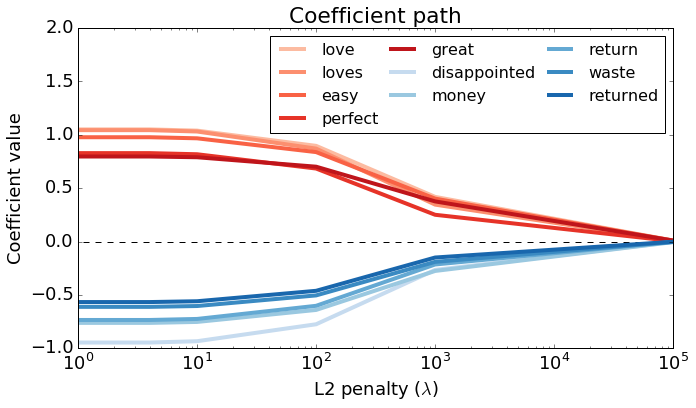

In [34]:
make_coefficient_plot(positive_words, negative_words, l2_penalty_list=[0, 4, 10, 1e2, 1e3, 1e5])

**Quiz Question**: (True/False) All coefficients consistently get smaller in size as the L2 penalty is increased.

**Quiz Question**: (True/False) The relative order of coefficients is preserved as the L2 penalty is increased. (For example, if the coefficient for 'cat' was more positive than that for 'dog', this remains true as the L2 penalty increases.)

## Measuring accuracy

Now, let us compute the accuracy of the classifier model. Recall that the accuracy is given by

$$
\mbox{accuracy} = \frac{\mbox{# correctly classified data points}}{\mbox{# total data points}}
$$


Recall from lecture that that the class prediction is calculated using
$$
\hat{y}_i = 
\left\{
\begin{array}{ll}
      +1 & h(\mathbf{x}_i)^T\mathbf{w} > 0 \\
      -1 & h(\mathbf{x}_i)^T\mathbf{w} \leq 0 \\
\end{array} 
\right.
$$

**Note**: It is important to know that the model prediction code doesn't change even with the addition of an L2 penalty. The only thing that changes is the estimated coefficients used in this prediction.

Based on the above, we will use the same code that was used in Module 3 assignment.

In [35]:
def get_classification_accuracy(feature_matrix, sentiment, coefficients):
    scores = np.dot(feature_matrix, coefficients.reshape(-1,1))
    
    predictions = scores.copy()
    predictions[predictions>0] = 1
    predictions[predictions<=0] = -1
    
    num_correct = (predictions == sentiment).sum()
    accuracy = num_correct / len(feature_matrix)
    return accuracy

Below, we compare the accuracy on the **training data** and **validation data** for all the models that were trained in this assignment.  We first calculate the accuracy values and then build a simple report summarizing the performance for the various models.

In [36]:
train_accuracy = {}
train_accuracy[0]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_0_penalty)
train_accuracy[4]   = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_4_penalty)
train_accuracy[10]  = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_10_penalty)
train_accuracy[1e2] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e2_penalty)
train_accuracy[1e3] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e3_penalty)
train_accuracy[1e5] = get_classification_accuracy(feature_matrix_train, sentiment_train, coefficients_1e5_penalty)

validation_accuracy = {}
validation_accuracy[0]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_0_penalty)
validation_accuracy[4]   = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_4_penalty)
validation_accuracy[10]  = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_10_penalty)
validation_accuracy[1e2] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e2_penalty)
validation_accuracy[1e3] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e3_penalty)
validation_accuracy[1e5] = get_classification_accuracy(feature_matrix_valid, sentiment_valid, coefficients_1e5_penalty)

In [37]:
# Build a simple report
for key in sorted(validation_accuracy.keys()):
    print("L2 penalty =",key)
    print("train accuracy =",train_accuracy[key],"validation_accuracy =",validation_accuracy[key])
    print("--------------------------------------------------------------------------------")

L2 penalty = 0
train accuracy = 0.785156157787 validation_accuracy = 0.78143964149
--------------------------------------------------------------------------------
L2 penalty = 4
train accuracy = 0.785108944548 validation_accuracy = 0.781533003454
--------------------------------------------------------------------------------
L2 penalty = 10
train accuracy = 0.784990911452 validation_accuracy = 0.781719727383
--------------------------------------------------------------------------------
L2 penalty = 100.0
train accuracy = 0.783975826822 validation_accuracy = 0.781066193633
--------------------------------------------------------------------------------
L2 penalty = 1000.0
train accuracy = 0.775855149784 validation_accuracy = 0.771356549342
--------------------------------------------------------------------------------
L2 penalty = 100000.0
train accuracy = 0.680366374731 validation_accuracy = 0.667818130893
---------------------------------------------------------------------------

* **Quiz question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **training** data?
* **Quiz question**: Which model (L2 = 0, 4, 10, 100, 1e3, 1e5) has the **highest** accuracy on the **validation** data?
* **Quiz question**: Does the **highest** accuracy on the **training** data imply that the model is the best one?